In [1]:
import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate as integrate
import timeit

Let's make our plots nice and pretty.

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

The following function just places a text box onto a plot.

In [3]:
def textbox(x, y, text, size=20, rot=0.0):
    plt.text(x, y, text, size=size, rotation=rot,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

`numpy.random` includes several different probability distribution functions.

Text(0, 0.5, 'frequency')

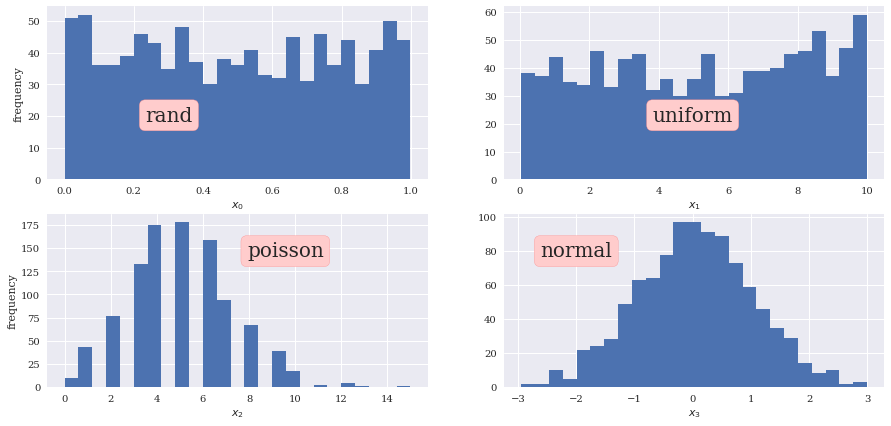

In [4]:
num_points = 1000

x0 = npr.rand(num_points)
x1 = npr.uniform(low=0, high=10, size=num_points)
x2 = npr.poisson(lam=5.0, size=num_points)
x3 = npr.normal(loc=0, scale=1, size=num_points)

x = np.vstack((x0, x1, x2, x3))

_, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
for axi, xi in zip([ax0, ax1, ax2, ax3], x):
    axi.hist(xi, bins=25)
ax0.set_xlabel('$x_0$')
ax1.set_xlabel('$x_1$')
ax2.set_xlabel('$x_2$')
ax3.set_xlabel('$x_3$')
textbox(-9, 160, 'rand')
textbox(0, 160, 'uniform')
textbox(-7, 80, 'poisson')
textbox(-2, 80, 'normal')
ax0.set_ylabel('frequency')
ax2.set_ylabel('frequency')

For reproducibility and apples-to-apples comparisons, always reset the seed for `numpy.random` as appropriate. 

In [5]:
SEED=500

For example, below, the $x_1$ array differs from $x_0$, $x_2$, and $x_3$ since the seed is not reset between calls to `numpy.random.rand()`.

Text(0, 0.5, 'frequency')

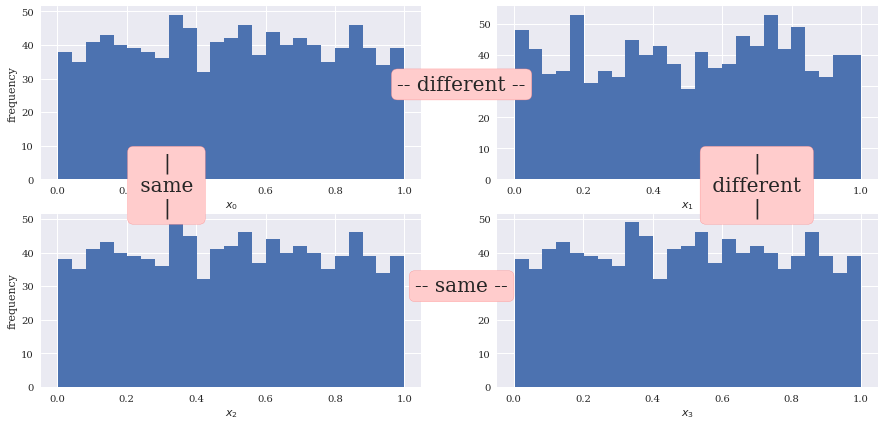

In [6]:
num_points = 1000

npr.seed(SEED)
x0 = npr.rand(num_points)
x1 = npr.rand(num_points)
npr.seed(SEED)
x2 = npr.rand(num_points)
npr.seed(SEED)
x3 = npr.rand(num_points)

x = np.vstack((x0, x1, x2, x3))

_, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
for axi, xi in zip([ax0, ax1, ax2, ax3], x):
    axi.hist(xi, bins=25)
ax0.set_xlabel('$x_0$')
ax1.set_xlabel('$x_1$')
ax2.set_xlabel('$x_2$')
ax3.set_xlabel('$x_3$')
textbox(-.15, 90, '-- different --')
textbox(.7, 60, '|\n different \n|')
textbox(-.15, 30, '-- same --')
textbox(-1, 60, '|\n same \n|')
ax0.set_ylabel('frequency')
ax2.set_ylabel('frequency')


*But of course, if you **want** different random numbers, don't reset the seed!*

## Monte Carlo integration

We want to estimate the integral  
        <center>$I = \int_a^b g(x) dx$</center>   
with a Monte Carlo approach:  
        <center>$\bar{I_n} \equiv \frac{1}{n}\sum_{i=1}^n I_i = \frac{b-a}{n}\sum_{i=1}^n g(a + (b-a) U_i)$,</center>  
where the $U$'s represent uniform random numbers between 0 and 1. Or, we can replace 
$g(a + (b-a) U_i)$ with a uniform random distribution between $a$ and $b$.

In [7]:
npr.seed(SEED)
num_points=1000

Let's define a function to integrate.

In [8]:
def fxn(x):
    #return np.sin(x)
    return np.sqrt(x**2 + 3.0 * x**3 + x**(1/4))

Five lines of code (or less!) to integrate.

In [9]:
(a, b) = (0.0, math.pi/2.0)
rn = npr.uniform(a, b, num_points)
fxn_x = fxn(rn)
(b - a) * np.mean(fxn_x)

3.021686844885284

We can make this a one-liner (for later use in `timeit.timeit()`).

In [10]:
npr.seed(SEED)
(b - a) * np.mean(fxn(npr.uniform(a, b, num_points)))

3.021686844885284

We'll call the `scipy.integrate.quad() result **exact**.

In [11]:
(exact, abserr) = integrate.quad(lambda x: fxn(x), 0, math.pi/2)

In [12]:
exact, abserr

(3.025042125193411, 3.2810199002142326e-11)

Let's explore how Monte Carlo does as a function of `num_points`.

In [13]:
scale = [1, 8]
num_points = np.asarray(10**np.arange(scale[0], scale[1]))
num_points

array([      10,      100,     1000,    10000,   100000,  1000000,
       10000000])

In [14]:
num_runs = 10
inte = []
timing = []
s = """\
inte.append((b - a) * np.mean(fxn(npr.uniform(a, b, num))))
"""
for num in num_points:
    timing.append(timeit.timeit(stmt=s, globals=globals(), number=num_runs))
inte = np.asarray(inte).reshape(scale[1]-scale[0], num_runs)
timing = np.asarray(timing)

In [15]:
inte

array([[3.54908976, 2.36381191, 2.93401745, 3.1377317 , 2.65348048,
        2.07443795, 2.97337412, 2.66669193, 3.82779421, 3.52009813],
       [2.9335809 , 3.06839829, 2.88177515, 3.01335157, 3.4349332 ,
        3.02632867, 3.10159059, 2.9532395 , 3.0001566 , 3.10477676],
       [3.01165483, 3.09695816, 3.03731841, 3.01870207, 2.99551568,
        2.93671682, 2.89326352, 2.91863856, 2.97927071, 3.03405093],
       [3.03728372, 3.03491832, 3.02726461, 3.01587387, 3.02602422,
        3.02928641, 3.03629947, 3.01026431, 3.03205638, 3.00663471],
       [3.02595373, 3.02832359, 3.0294656 , 3.02774786, 3.02450888,
        3.02113175, 3.02830999, 3.02949433, 3.02308159, 3.02447993],
       [3.02898833, 3.02444917, 3.02487031, 3.0246818 , 3.02427823,
        3.02464058, 3.0284446 , 3.02404705, 3.02348103, 3.02440891],
       [3.02484541, 3.02514502, 3.02469255, 3.02556918, 3.02504971,
        3.02566522, 3.02483566, 3.02485771, 3.02498066, 3.025359  ]])

In [16]:
inte_avg = np.mean(inte, axis=1)

In [17]:
inte_avg

array([2.97005276, 3.05181313, 2.99220897, 3.0255906 , 3.02624972,
       3.025229  , 3.02510001])

The root mean square error is one measure of accuracy.

In [18]:
inte_rmse = np.sqrt(np.sum((exact - inte)**2, axis=1)/num_runs)

In [19]:
inte_rmse

array([5.28688747e-01, 1.47279172e-01, 6.71406817e-02, 1.04331919e-02,
       2.97864595e-03, 1.79536135e-03, 3.19123627e-04])

We can look at the RMSE and timing as a function of num_points.

In [20]:
np.vstack((num_points, inte_rmse, num_runs*timing)).T

array([[1.00000000e+01, 5.28688747e-01, 5.20545000e-03],
       [1.00000000e+02, 1.47279172e-01, 3.66564000e-03],
       [1.00000000e+03, 6.71406817e-02, 1.86633800e-02],
       [1.00000000e+04, 1.04331919e-02, 6.53774000e-02],
       [1.00000000e+05, 2.97864595e-03, 6.59178450e-01],
       [1.00000000e+06, 1.79536135e-03, 5.39856352e+00],
       [1.00000000e+07, 3.19123627e-04, 5.64467328e+01]])

For this 1D function, scipy is still the way to go to get a quick and accurate result.

In [21]:
timeit.timeit('integrate.quad(lambda x: np.sin(x), 0, math.pi/2)', globals=globals(), number=10)

0.0003644480000009054

When performing Monte Carlo studies, it's important to evaluate convergence, so let's create a numpy array for all of our results (num_points, inte).

In [55]:
inte_scale = np.empty((num_runs * len(num_points), 2))
for i in range(len(num_points)):
    for j in range(num_runs):
        inte_scale[i*num_runs + j] = np.asarray([num_points[i], inte[i][j]])

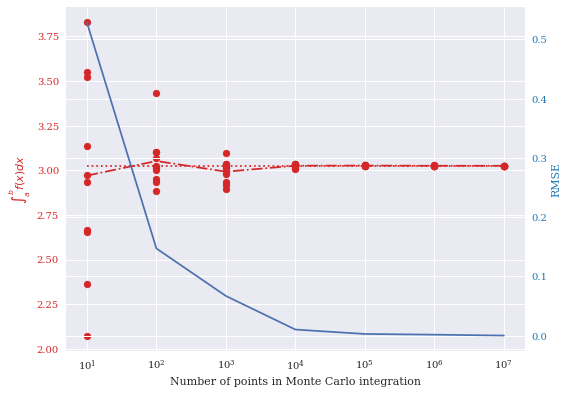

In [64]:
fig,ax = plt.subplots()

color = 'tab:red'
ax.scatter(inte_scale.T[0], inte_scale.T[1], color=color)
ax.plot(num_points, exact*np.ones(scale[1] - scale[0]), color=color, linestyle='dotted')
ax.plot(num_points, inte_avg, color=color, linestyle='dashdot')
ax.set_xlabel('Number of points in Monte Carlo integration')
ax.set_ylabel('$\int_a^b f(x) dx$', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.plot(num_points, inte_rmse)
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xscale('log')

For methods to integrate more complicated multi-dimensional functions (for which Monte Carlo methods may actually make sense), see:  
  
[Monte Carlo Integration libraries in GSL](https://www.gnu.org/software/gsl/doc/html/montecarlo.html)